Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



<IPython.core.display.Javascript object>


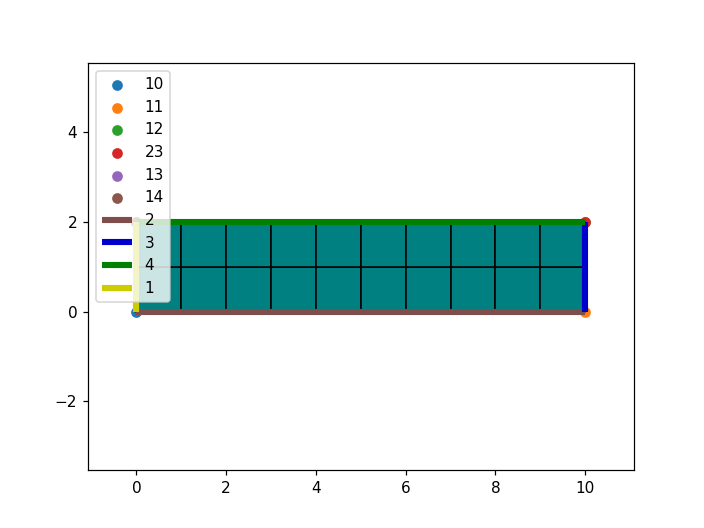

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from scipy.fftpack import rfft, fftfreq, fft
import scipy.sparse as sparse
import scipy.linalg as linalg
from scipy.sparse.linalg import LinearOperator
import numpy as np
import collections
import copy
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator
import amfe
from amfe.frequency_module import frequency
from scipy import optimize
#unpack case dict

msh_file = r'meshes\2D_beam_20_elem.msh'
m = amfe.Mesh()
m.import_msh(msh_file)

ax= amfe.plot_mesh(m)
ax.axis('equal')
ax.legend(loc=2)

In [2]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)

rho = 7.86E3 # kg/m3
E = 210.0E9 # MPa = N/m2
my_material = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, thickness=1, plane_stress=True)
my_comp.set_domain(6,my_material)


print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 20 elements and 66 dofs.
Time taken for preallocation: 0.00 seconds.
Number of nodes is equal to 33


In [3]:
dirsub = m.get_submesh('phys_group', 1)
neusub = m.get_submesh('phys_group', 12)
contactsub = m.get_submesh('phys_group', 11)
domain = m.get_submesh('phys_group', 6)
id_matrix = my_comp.assembly_class.id_matrix

# get dofs
all_dofs = OrderedSet(my_comp.get_dofs(domain,direction ='xy'))
dir_dofs = OrderedSet(my_comp.get_dofs(dirsub, direction ='xy'))
neu_dofs = OrderedSet(my_comp.get_dofs(neusub, direction ='y'))
contact_dofs = OrderedSet(my_comp.get_dofs(contactsub, direction ='y'))


boundary_dofs = dir_dofs | neu_dofs | contact_dofs
interior_dofs = list(OrderedSet(all_dofs) - boundary_dofs)
dir_dofs = list(dir_dofs)
neu_dofs = list(neu_dofs)
contact_dofs = list(contact_dofs)

dof_dict = collections.OrderedDict()
dof_dict['d'] = dir_dofs 
dof_dict['n'] = neu_dofs
dof_dict['c'] = contact_dofs
dof_dict['i'] = interior_dofs

s = SelectionOperator(dof_dict,id_matrix)


WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils


In [4]:
K, f = my_comp.assembly_class.assemble_k_and_f()
M = my_comp.assembly_class.assemble_m()

In [14]:
def cubic_string(beta):
    
    return lambda u : beta*(u**3)

def build_nonlinear_force_in_freq(fnl,Q,Bc):
    
    return lambda u_ : Bc.T.dot(Bc.dot(Q.T.dot((fnl(Q.dot(u_))))))
    
def build_nonlinear_force_in_freq_with_Q_red(fnl,Q_red):
    
    return lambda u_ : Q_red.T.dot((fnl(Q_red.dot(u_))))
    
def build_residual(Z,fnl_,fl_):
    ''' 
    Parameters
        Z : np.array
            Dynamic stiffness matrix
        fnl : lambda function
            
        
    '''
    
    return lambda u_ : Z.dot(u_) + fnl_(u_) - fl_




number_of_harm=5
value = -1
n_points = 100
beta = 0.0
alpha = 0.0
gamma = 0.0
complex_data= False
static=False

# Harmonic Analysis
K_red = s.assemble_matrix(K,['n','c','i'])
M_red = s.assemble_matrix(M,['n','c','i'])
C_red = alpha*K_red + gamma*M_red

Bc_red = s.reduced_selector.build_B('c')
Bn_red = s.reduced_selector.build_B('n')
amplitute_dim = K_red.shape[0] 
I = sparse.eye(amplitute_dim)
u_ = 0.0*np.random.rand(number_of_harm*K_red.shape[0])

def compute_max_amplitude(f0):
    global u_
    force_in_time = frequency.linear_harmonic_force(a=value, f0 = f0, n_points=n_points, cos=True)
    q = frequency.hbm_complex_bases(f0,number_of_harm=number_of_harm,n_points=n_points, static=static, complex_data= complex_data)
    Z_red = frequency.create_Z_matrix(K_red,C_red,M_red,f0=f0,nH=number_of_harm, static=static, complex_data= complex_data)

    fl_1dof_ = q.T.dot(force_in_time) # creating 1 dof force in Frequency domain


    # building multidimentional Harmonic Basis
    

    Q = sparse.kron(I,q)
    I_harm = sparse.eye(number_of_harm)
    Bc_aug = sparse.kron(I_harm, Bc_red)
    Bn_aug = sparse.kron(I_harm, Bn_red)
    Q_red = sparse.kron(Bc_red ,q)
    #fl_aug_ = sparse.kron(I_harm, fl_)


    fnl = cubic_string(beta)
    fnl_ = build_nonlinear_force_in_freq(fnl,Q,Bc_aug)
    fnl2_ = build_nonlinear_force_in_freq_with_Q_red(fnl,Q_red)
    fl_ = Bn_aug.T.dot(fl_1dof_) # creating multiple dofs force in Frequency domain
    R_func = build_residual(Z_red,fnl_,fl_)

    ul_ = sparse.linalg.spsolve(Z_red,fl_)
    u_ = ul_
    
    R_func(u_)
    opt_obj = optimize.root(R_func,u_,method='krylov')
    x0 = opt_obj.x
    u_ = x0 # initial guess for the next iteration
    
    u_dir = np.array(len(s.selection_dict['d'])*[0])
    get_amplitute_by_t_id = lambda t_id : sparse.kron(q[t_id,:],I).dot(x0)

    u_ndym = []
    for t_id in range(n_points):
        unl_ = get_amplitute_by_t_id(t_id)
        u = np.append(u_dir,unl_)    
        u_ndym.append(s.P.T.dot(u)) # back to original order

    contact_dof = s.selection_dict['c'][0]
    contact_dof_in_time = np.array(u_ndym).T[contact_dof]
    t = list(range(0,len(contact_dof_in_time)))
    u_max = max(np.abs(contact_dof_in_time))
    shift_max = max(np.angle(contact_dof_in_time))
    return u_max, shift_max, contact_dof_in_time

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [15]:
#f0 = 30.0
u_list = []
shift_list = []
freq_list = list(range(2,1001,2))
for f0 in freq_list:
    u_max, shift_max, contact_dof_in_time = compute_max_amplitude(f0)
    u_list.append(u_max)
    shift_list.append(shift_max)
    

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\optimize\nonlin.py:476: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


29 s ± 1.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


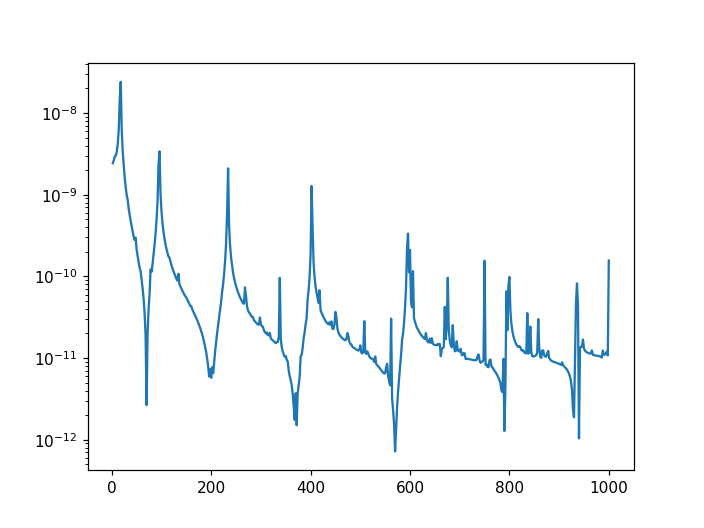

In [16]:
plt.figure()
plt.plot(freq_list,u_list)
#plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')